# Loading Libraries

Doing some experimentations I notice that there was a CUDA error coming with older version of PyTorch, so it's advisable to upgrade PyTorch version.

In [ ]:
!pip install --upgrade torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 115.4 MB/s eta 0:00:01tcmalloc: large alloc 1147494400 bytes == 0x64f10000 @  0x7fc946cd5615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 6.6 kB/s 
     |████████████████████████████████| 557.1 MB 9.6 kB/s 
     |████████████████████████████████| 317.1 MB 36 kB/s 
     |████████████████████████████████| 21.0 MB 81.0 MB/s 
     |████████████████████████████████| 849 kB 83.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency res

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 73.0 MB/s 
     |████████████████████████████████| 182 kB 71.6 MB/s 


In [2]:
import time
import random
import datetime
import numpy as np
import pandas as pd

from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import tensorflow as tf
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import BertForSequenceClassification, AdamW, BertConfig

from tqdm import tqdm

In [3]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# If there's a GPU available...
if torch.cuda.is_available():    

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")    

There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


# Loading Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
inputData = pd.read_csv("/content/drive/MyDrive/CS-688_Project/IMDB/IMDB_large.csv")

In [6]:
inputData.head()

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw1133942,OriginalMovieBuff21,Kill Bill: Vol. 2 (2004),8.0,Good follow up that answers all the questions,24 July 2005,0,"After seeing Tarantino's Kill Bill Vol: 1, I g...","['0', '1']"
1,rw1133954,diand_,The Amityville Horror (2005),3.0,Laid-back horror,24 July 2005,0,The Amityville Horror is once again a horror m...,"['0', '1']"
2,rw1133956,Aaron1375,Phantasm III: Lord of the Dead (1994),6.0,Be careful of what you wish for.,24 July 2005,0,The first installment of this series explained...,"['0', '4']"
3,rw1133959,lost-in-limbo,Feardotcom (2002),3.0,"""I couldn't make much sense of it myself"". Too...",24 July 2005,0,There's a Website called FearDotCom and anyone...,"['1', '4']"
4,rw1133973,theowinthrop,Out to Sea (1997),6.0,"Amusing Follow Up to the Two ""Grumpies""",24 July 2005,0,After the making of GRUMPY OLD MEN and GRUMPIE...,"['7', '10']"


In [7]:
inputData = inputData.drop(['review_id','reviewer','movie','review_summary','review_date','spoiler_tag','helpful'], axis=1)
inputData.head()

,rating,review_detail
0,8.0,"After seeing Tarantino's Kill Bill Vol: 1, I g..."
1,3.0,The Amityville Horror is once again a horror m...
2,6.0,The first installment of this series explained...
3,3.0,There's a Website called FearDotCom and anyone...
4,6.0,After the making of GRUMPY OLD MEN and GRUMPIE...


In [8]:
#removing null values
print("before removing duplicates and null values: ",inputData.shape)
inputData.dropna(inplace=True)
inputData.drop_duplicates(inplace=True)
print("after removing duplicates and null values: ",inputData.shape)

before removing duplicates and null values:  (776414, 2)
after removing duplicates and null values:  (657995, 2)


In [9]:
inputData.drop_duplicates(inplace=True)
inputData.duplicated().sum()

0

In [10]:
data = inputData.rename(columns={"rating": 0, "review_detail": 1})
data

,0,1
0,8.0,"After seeing Tarantino's Kill Bill Vol: 1, I g..."
1,3.0,The Amityville Horror is once again a horror m...
2,6.0,The first installment of this series explained...
3,3.0,There's a Website called FearDotCom and anyone...
4,6.0,After the making of GRUMPY OLD MEN and GRUMPIE...
...,...,...
776409,8.0,Every conscientious high school educator ought...
776410,5.0,You know when a movie is in trouble when its f...
776411,4.0,I've known the Garfield comic all my life (Gar...
776412,7.0,The Tomb of Ligeia sets itself apart from the ...


In [11]:
data[0] = data[0].apply(lambda x: 2 if x>5 else 1)
data[0].value_counts()

2    505459
1    152536
Name: 0, dtype: int64

In [12]:
data = data.reset_index(drop=True)
data

,0,1
0,2,"After seeing Tarantino's Kill Bill Vol: 1, I g..."
1,1,The Amityville Horror is once again a horror m...
2,2,The first installment of this series explained...
3,1,There's a Website called FearDotCom and anyone...
4,2,After the making of GRUMPY OLD MEN and GRUMPIE...
...,...,...
657990,2,Every conscientious high school educator ought...
657991,1,You know when a movie is in trouble when its f...
657992,1,I've known the Garfield comic all my life (Gar...
657993,2,The Tomb of Ligeia sets itself apart from the ...


In [13]:
izuo1 = data.loc[data[0] == 1]
izuo2 = data.loc[data[0] == 2]

In [14]:
train1 = izuo1[:100000]
train2 = izuo2[:100000]

In [15]:
#concading tran1 and train2
frames = [train1, train2]
data = pd.concat(frames)

In [16]:
data = data.reset_index(drop=True)

In [17]:
data

,0,1
0,1,The Amityville Horror is once again a horror m...
1,1,There's a Website called FearDotCom and anyone...
2,1,Spielberg said this film is based on the H.G. ...
3,1,"Unnecessary, redundant, pointless. I don't kno..."
4,1,I've watched this film several times over the ...
...,...,...
199995,2,It's not very often that you get such wonderfu...
199996,2,The story of Snow White & the Seven Dwarfs has...
199997,2,I found the first two thirds of this movie ver...
199998,2,One of the best British spy movies ever made. ...


# Processing Data

In [18]:
data[0].value_counts()

1    100000
2    100000
Name: 0, dtype: int64

In [19]:
data.rename(columns = {0:'sentiment', 1:'review'}, inplace = True)
data

,sentiment,review
0,1,The Amityville Horror is once again a horror m...
1,1,There's a Website called FearDotCom and anyone...
2,1,Spielberg said this film is based on the H.G. ...
3,1,"Unnecessary, redundant, pointless. I don't kno..."
4,1,I've watched this film several times over the ...
...,...,...
199995,2,It's not very often that you get such wonderfu...
199996,2,The story of Snow White & the Seven Dwarfs has...
199997,2,I found the first two thirds of this movie ver...
199998,2,One of the best British spy movies ever made. ...


In [20]:
df=data

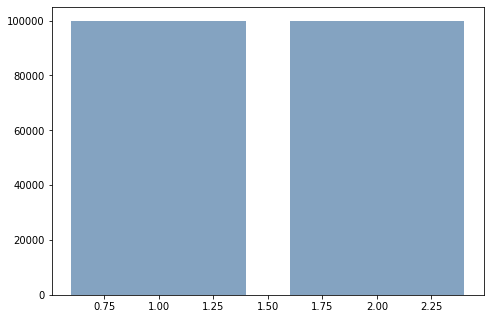

In [21]:
sentence = df['review'].tolist()
label1 = df['sentiment'].tolist()

c = Counter(label1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Intent = []
Occurance = []
for i in c.items():
  Intent.append(i[0])
  Occurance.append(i[1])
ax.bar(Intent,Occurance,color=(0.2, 0.4, 0.6, 0.6))  
plt.show()


# Data Preparation

In [22]:
dic={1:0,2:1}
ans={0:1,1:2}

In [23]:
labels=data['sentiment']
sentence=data['review']

for i in tqdm(range(len(labels))):
  labels[i]=dic[labels[i]]

  0%|          | 0/200000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 200000/200000 [00:48<00:00, 4129.28it/s]


In [24]:
for i in range(len(label1)):
 label1[i]=dic[label1[i]]

data={'sentence':sentence,'label1':labels}
df=pd.DataFrame(data)
print(len(df))
df=df.drop_duplicates()
print(len(df))

200000
199979


In [28]:
X_train, X_test, y_train, y_test = train_test_split(sentence, label1, test_size = 0.20, random_state = 0, stratify=label1)

In [29]:
pd.DataFrame(y_train).value_counts()

0    80000
1    80000
dtype: int64

In [30]:
pd.DataFrame(y_test).value_counts()

0    20000
1    20000
dtype: int64

In [31]:
sentences = X_train
labels = y_train

In [32]:
numClasses = 2
label_1_num_classes = numClasses
label1 = torch.LongTensor(labels)

# Loading RoBERTa Model and Creating Data Frame

In [33]:
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Loading RoBERTa tokenizer...


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

 Original:  The Amityville Horror is once again a horror movie with surprisingly little gore and tries to build its based-on-true-events story with attention to psychological forces, tension building and a house. Some people compare it to The Shining. There is even the obligatory overhead shot referring to this movie. But they are worlds apart. This is so lazy and unimaginative in its execution that it is hardly lifted above the average. The house offered many possibilities to explore as a character (with its ghosts) but all the shots in and around the house are without any imagination. As Chelsea enters the roof there are few shots suggesting depth. As the ghosts are shown, they have almost no dramatic impact on the viewer. The transformation of George the father is not very insightful portrayed for the viewer: He turns from father to maniac in an instant and that's not very plausible. A plot twist could have helped the movie regain some interest half-way (e.g. George non-existent but

In [34]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in tqdm(sentences):
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 512,pad_to_max_length = True,
                        return_attention_mask = True, return_tensors = 'pt',)
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
all_labels = torch.stack([label1], dim=1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

  0%|          | 0/160000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 160000/160000 [02:51<00:00, 934.18it/s]


Original:  The Amityville Horror is once again a horror movie with surprisingly little gore and tries to build its based-on-true-events story with attention to psychological forces, tension building and a house. Some people compare it to The Shining. There is even the obligatory overhead shot referring to this movie. But they are worlds apart. This is so lazy and unimaginative in its execution that it is hardly lifted above the average. The house offered many possibilities to explore as a character (with its ghosts) but all the shots in and around the house are without any imagination. As Chelsea enters the roof there are few shots suggesting depth. As the ghosts are shown, they have almost no dramatic impact on the viewer. The transformation of George the father is not very insightful portrayed for the viewer: He turns from father to maniac in an instant and that's not very plausible. A plot twist could have helped the movie regain some interest half-way (e.g. George non-existent but 

In [35]:
dataset = TensorDataset(input_ids, attention_masks, all_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

144,000 training samples
16,000 validation samples


# Training on label 1

In [36]:
batch_size = 32
train_dataloader = DataLoader( train_dataset, shuffle=True, batch_size = batch_size)
validation_dataloader = DataLoader( val_dataset, shuffle=False, batch_size = batch_size )


model = RobertaForSequenceClassification.from_pretrained( 
    "roberta-base", num_labels = numClasses, output_attentions = False, output_hidden_states = False)

model.cuda()

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [37]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [38]:
def flat_accuracy(preds1,labels):
    pred_flat1 = np.argmax(preds1, axis=1).flatten()
    labels = labels.flatten() 
    labels_flat1=np.asarray(labels)
    acc1= np.sum(pred_flat1 == labels_flat1) / len(labels_flat1)
    #return (acc1+acc2)/2
    return acc1

In [39]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [40]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # print(b_labels.shape)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       return_dict=True)
        label1_preds = result["logits"][:, :6]
        label1_loss = torch.nn.functional.cross_entropy(label1_preds, b_labels[:, 0])


        loss = label1_loss

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy1 = 0
    total_eval_accuracy2 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           return_dict=True)

        label1_preds = result["logits"][:, :label_1_num_classes]
        label1_loss = torch.nn.functional.cross_entropy(label1_preds, b_labels[:, 0])


        loss = label1_loss 
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        label1_preds = label1_preds.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        eval_1 = flat_accuracy(label1_preds,label_ids)
        total_eval_accuracy1+=eval_1

    # Report the final accuracy for this validation run.
    avg_val_accuracy1 = total_eval_accuracy1 / len(validation_dataloader)
    print("  Accuracy1: {0:.2f}".format(avg_val_accuracy1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur. Label1.': avg_val_accuracy1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    path = "epoch_"+str(epoch_i)+"_check.pth"
    torch.save(model.state_dict(), path)
 
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  4,500.    Elapsed: 0:00:31.
  Batch    80  of  4,500.    Elapsed: 0:00:59.
  Batch   120  of  4,500.    Elapsed: 0:01:27.
  Batch   160  of  4,500.    Elapsed: 0:01:55.
  Batch   200  of  4,500.    Elapsed: 0:02:24.
  Batch   240  of  4,500.    Elapsed: 0:02:52.
  Batch   280  of  4,500.    Elapsed: 0:03:20.
  Batch   320  of  4,500.    Elapsed: 0:03:48.
  Batch   360  of  4,500.    Elapsed: 0:04:16.
  Batch   400  of  4,500.    Elapsed: 0:04:45.
  Batch   440  of  4,500.    Elapsed: 0:05:13.
  Batch   480  of  4,500.    Elapsed: 0:05:41.
  Batch   520  of  4,500.    Elapsed: 0:06:09.
  Batch   560  of  4,500.    Elapsed: 0:06:37.
  Batch   600  of  4,500.    Elapsed: 0:07:06.
  Batch   640  of  4,500.    Elapsed: 0:07:34.
  Batch   680  of  4,500.    Elapsed: 0:08:02.
  Batch   720  of  4,500.    Elapsed: 0:08:30.
  Batch   760  of  4,500.    Elapsed: 0:08:59.
  Batch   800  of  4,500.    Elapsed: 0:09:27.
  Batch   840  of

# Calculating testing accuracy.

In [41]:
data={'sentence':X_test,'label':y_test}
df=pd.DataFrame(data, columns =['label','sentence']) 

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

label_1_num_classes = numClasses

# from sklearn.preprocessing import LabelEncoder

# label1_encoder = LabelEncoder()

# label1 = [item[0] for item in labels]
# label1 = label1_encoder.fit_transform(label1)

label1 = torch.LongTensor(labels)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                sent,add_special_tokens = True,max_length = 512,pad_to_max_length = True, return_attention_mask = True,return_tensors = 'pt',)
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
all_labels = torch.stack([label1], dim=1)

# Set the batch size.  
batch_size = 32  


# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, all_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, shuffle=False, batch_size=batch_size)

Number of test sentences: 40,000



In [42]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
prediction_list = []
real_list=[]
accuracy1 = 0
total_count = 0
misclassify1=0
misclassify_data=[]

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  #logits = result.logits
  label1_preds = result["logits"][:, :label_1_num_classes]

  # Move logits and labels to CPU
  label1_preds = label1_preds.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  label1_preds=np.argmax(label1_preds,axis=1)
  label_ids = label_ids.flatten()

  for i in range(len(label_ids)):
    prediction_list.append(label1_preds[i])
    real_list.append(label_ids[i])
    if(label1_preds[i]==label_ids[i]):
      accuracy1+=1
    else:
      misclassify1+=1

print("")

print("Number of Label1 correctly predicted: "+str(accuracy1))
print("Number of Label1 misclassify: "+str(misclassify1))

print("Label1 Testing Accuracy: {:.2f}".format(accuracy1/(accuracy1+misclassify1) ) )
bert_singlelabel_accuracy1 = accuracy1/(accuracy1+misclassify1)

Predicting labels for 40,000 test sentences...

Number of Label1 correctly predicted: 36618
Number of Label1 misclassify: 3382
Label1 Testing Accuracy: 0.92


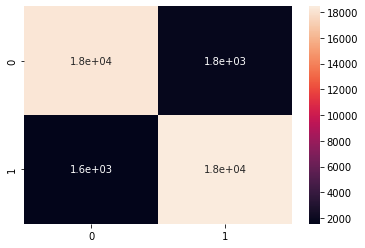

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(real_list,prediction_list), annot=True)